<center><img src="https://github.com/khaykingleb/Applied-Data-Science/blob/main/homeworks/hw_01/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание: генеративно-состязательные сети</center></h2>

Выполнил: Хайкин Глеб, ИАД 5

# Введение

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) — это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

Телескопами MAGIC в настоящее время управляют около 165 астрофизиков из 24 организаций и консорциумов из 12 стран. MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="https://github.com/khaykingleb/Applied-Data-Science/blob/main/homeworks/hw_01/img/magic1.jpg?raw=1" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. По фотографиям можно определить тип частицы из космоса: фотон или протон.

<center><img src="https://github.com/khaykingleb/Applied-Data-Science/blob/main/homeworks/hw_01/img/shower.jpg?raw=1" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа — получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Есть два вида параметров изображения: параметры формы и параметры ориентации. (Источник: http://ihp-lx.ethz.ch/Stamet/magic/parameters.html)

<center><img src="https://github.com/khaykingleb/Applied-Data-Science/blob/main/homeworks/hw_01/img/geo.jpg?raw=1" width="400"></center>

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.


<center><img src="https://github.com/khaykingleb/Applied-Data-Science/blob/main/homeworks/hw_01/img/gamma_p.png?raw=1" width="600"></center>

## Ускорение симуляции

Сложные физические симуляторы требуют больших вычислительных ресурсов. Они моделируют прилет частиц из космоса, их взаимодействие с атмосферой, рождение ливней, черенковского излучения и работы телескопов для получения изображений. Но мы можем использовать генеративно-состязательные сети для быстрой симуляции!

In [1]:
### Оформление кода
from typing import List, Tuple, Dict, Union, Optional
from typing_extensions import Literal

### Картинки
import matplotlib as mpl
import matplotlib.pyplot as plt

# Стиль и четкость
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Шрифт
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.sans-serif": ["Benton Sans"]})

# Анимация
from IPython.display import clear_output

# Фиксируем размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

### Основное
# БД
import pandas as pd

# Математика
import numpy as np
import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
from google.colab import files
uploaded = files.upload()

Saving magic04.data to magic04 (1).data


In [3]:
names = np.array(['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist', 'class'])
data = pd.read_csv('magic04.data', header=None)
data.columns = names
data

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научится генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ — матрица реальных объектов, которые нужно научиться генерировать;
- $y$ — метки классов, которые будем использовать как условие при генерации.

In [4]:
# Параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# Метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == 'h'] = 0

In [5]:
X[:10]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02],
       [1.62052e+02, 1.36031e+02, 4.06120e+00, 3.74000e-02, 1.87000e-02,
        1.16741e+02, 6.48580e+01, 4.52160e+01, 7.69600e+01, 2.56788e+02],
       [2.38172e+01, 9.57280e+00, 2.33850e+00, 6.14700e-01, 3.92200e-01,
        2.72107e+01, 6.46330e+00, 7.15130e+00, 1.04490e+01, 1.16737e+02],
       [7.51362e+01, 3.09205e+01, 3.16110e+00, 3.16800e-01, 1.83200e-01,
        5.52770e+00, 2.85525e+01, 2.18393e+01, 4.64800e+00, 3.56462e+02],
       [5.16240e+01, 2.11502e+01, 2.90850e+00, 2.42000e-01, 1.34000e-01,
        5.08761e+01, 4.31887e+01, 9.81450e+00, 3.61300e+00, 2.38098e+02],
       [4.82468e+01, 1.73565e+01, 3.03320e+00, 2.52900e-01, 1.51500e-01,
        8.57300e+00, 3.80957e+01, 1.05868e+01

In [6]:
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [7]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(4*4, 4*2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i+1)
        plt.hist(X1[:, i], bins=bins, alpha=0.5, label=label1, color='C0')
        plt.hist(X2[:, i], bins=bins, alpha=0.5, label=label2, color='C1')
        plt.xlabel(names[i], size=14)
        plt.legend(loc='best')
    plt.tight_layout()

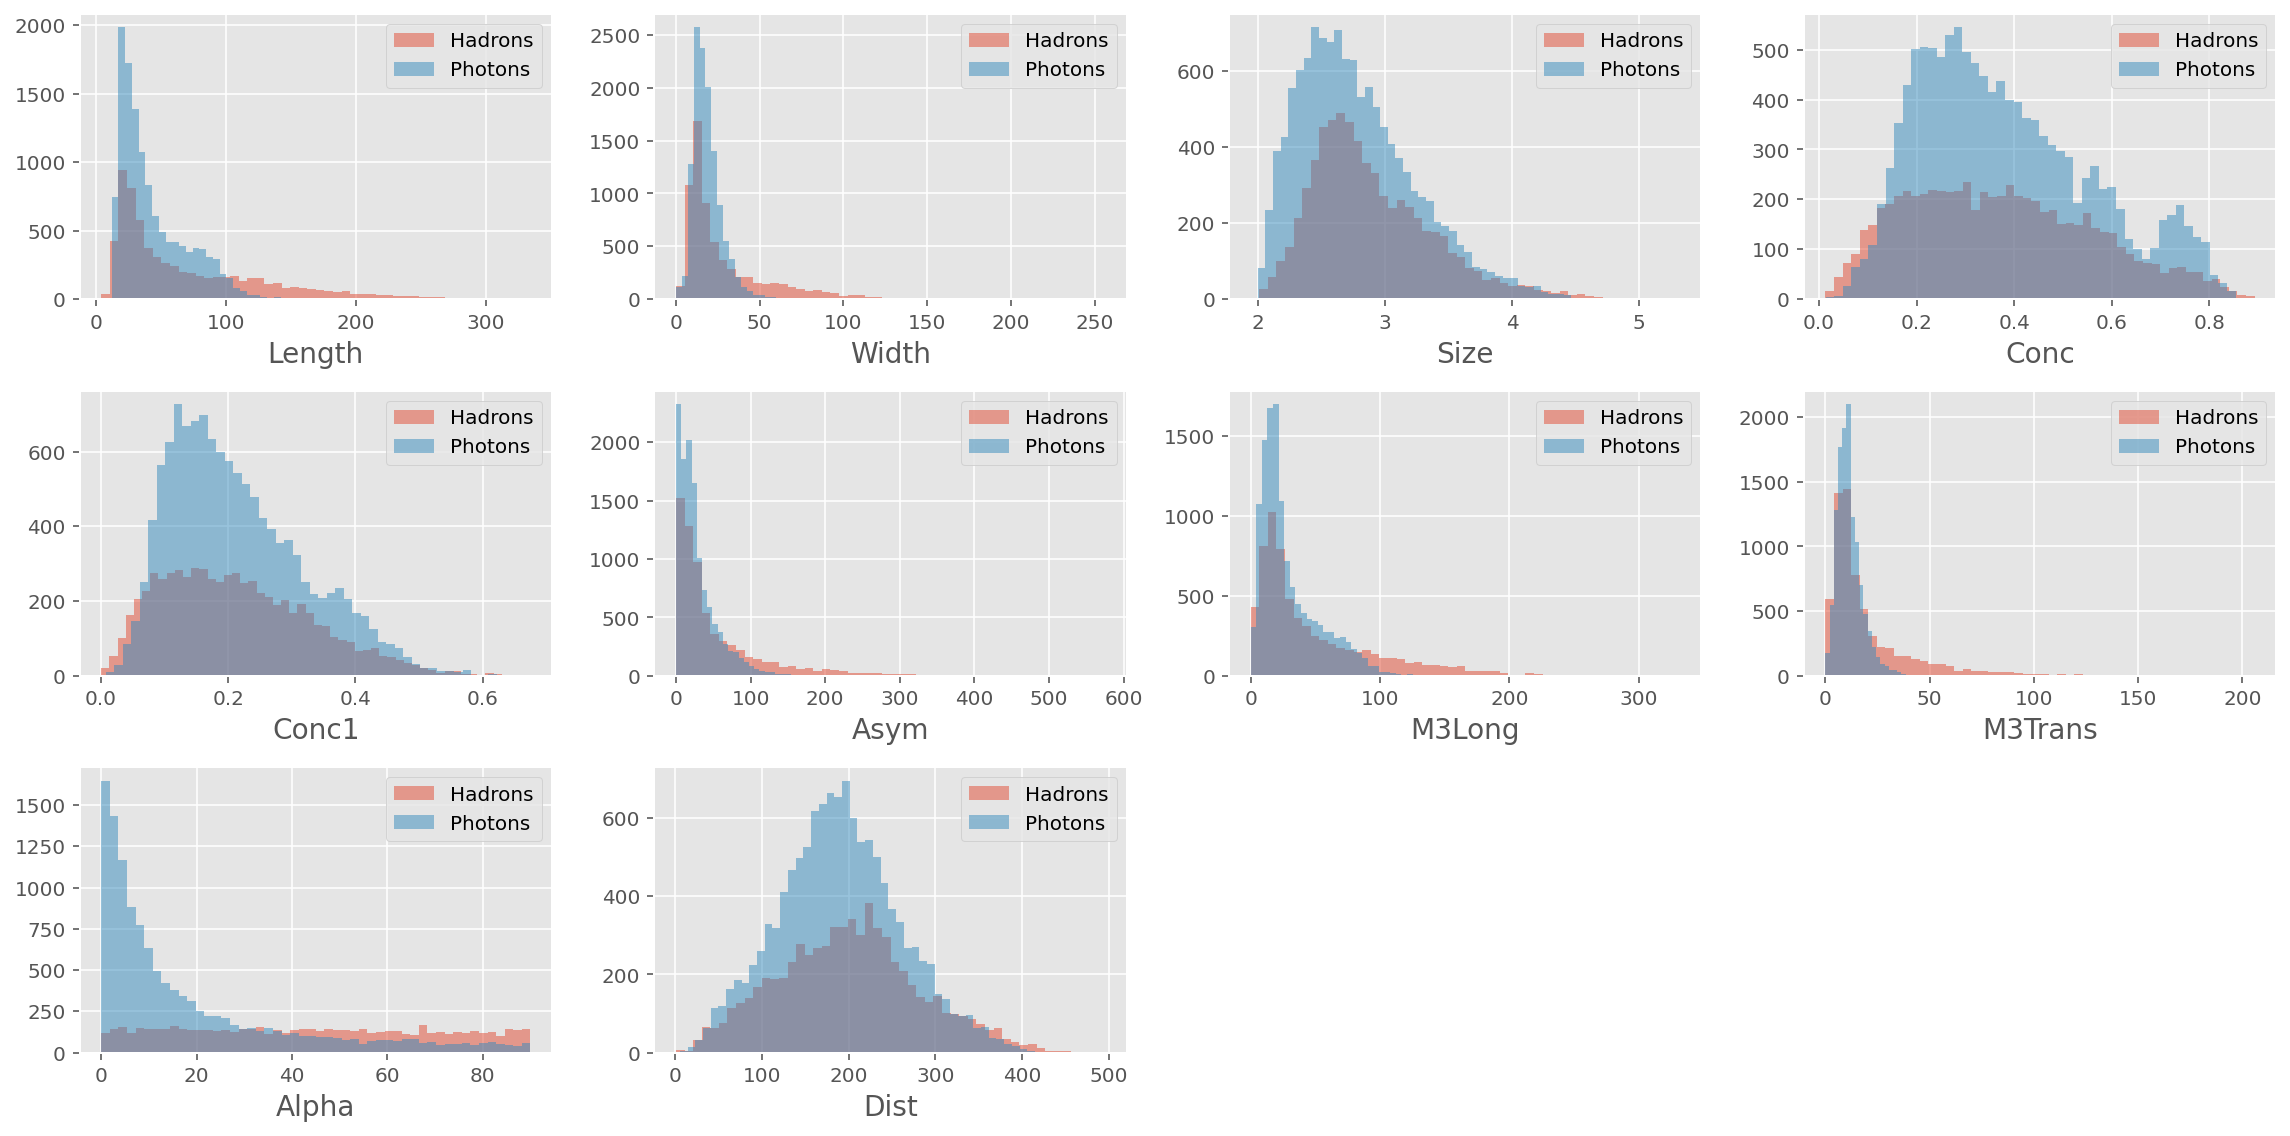

In [8]:
plot_hists(X[y[:, 0]==0], X[y[:, 0]==1], names, label1="Hadrons", label2="Photons", bins=50)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому, нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты. 

## Задание 1 (1 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. 

In [9]:
from sklearn.preprocessing import QuantileTransformer

In [10]:
qt = QuantileTransformer(random_state=77, output_distribution='normal')
X_qt = qt.fit_transform(X) 

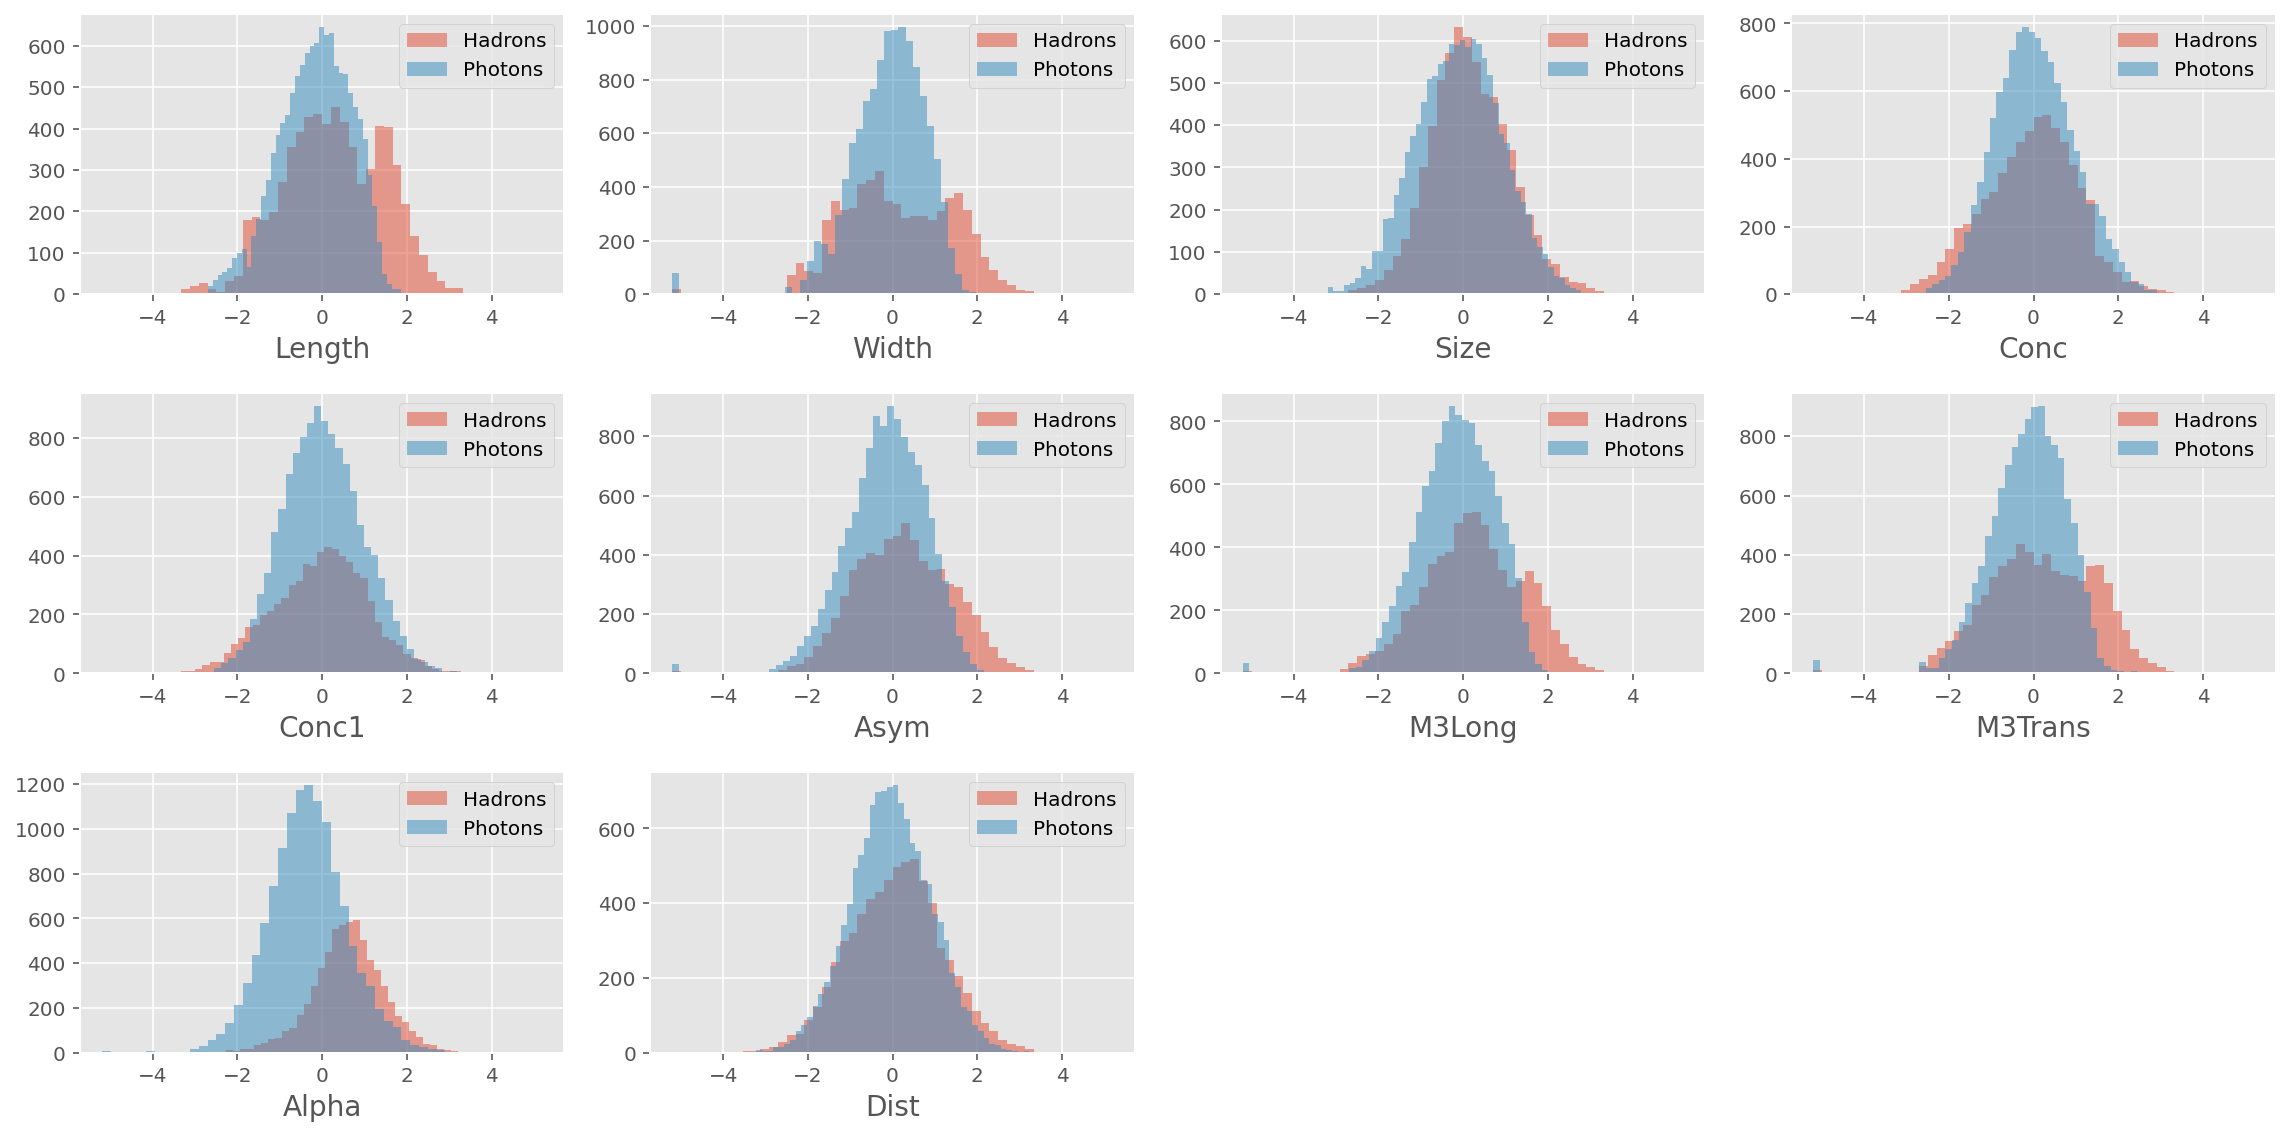

In [11]:
plot_hists(X_qt[y[:, 0]==0], X_qt[y[:, 0]==1], names, label1="Hadrons", label2="Photons", bins=50)

# Обучающая и тестовая выборки

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_qt, y, stratify=y, test_size=0.5, shuffle=True, random_state=11)

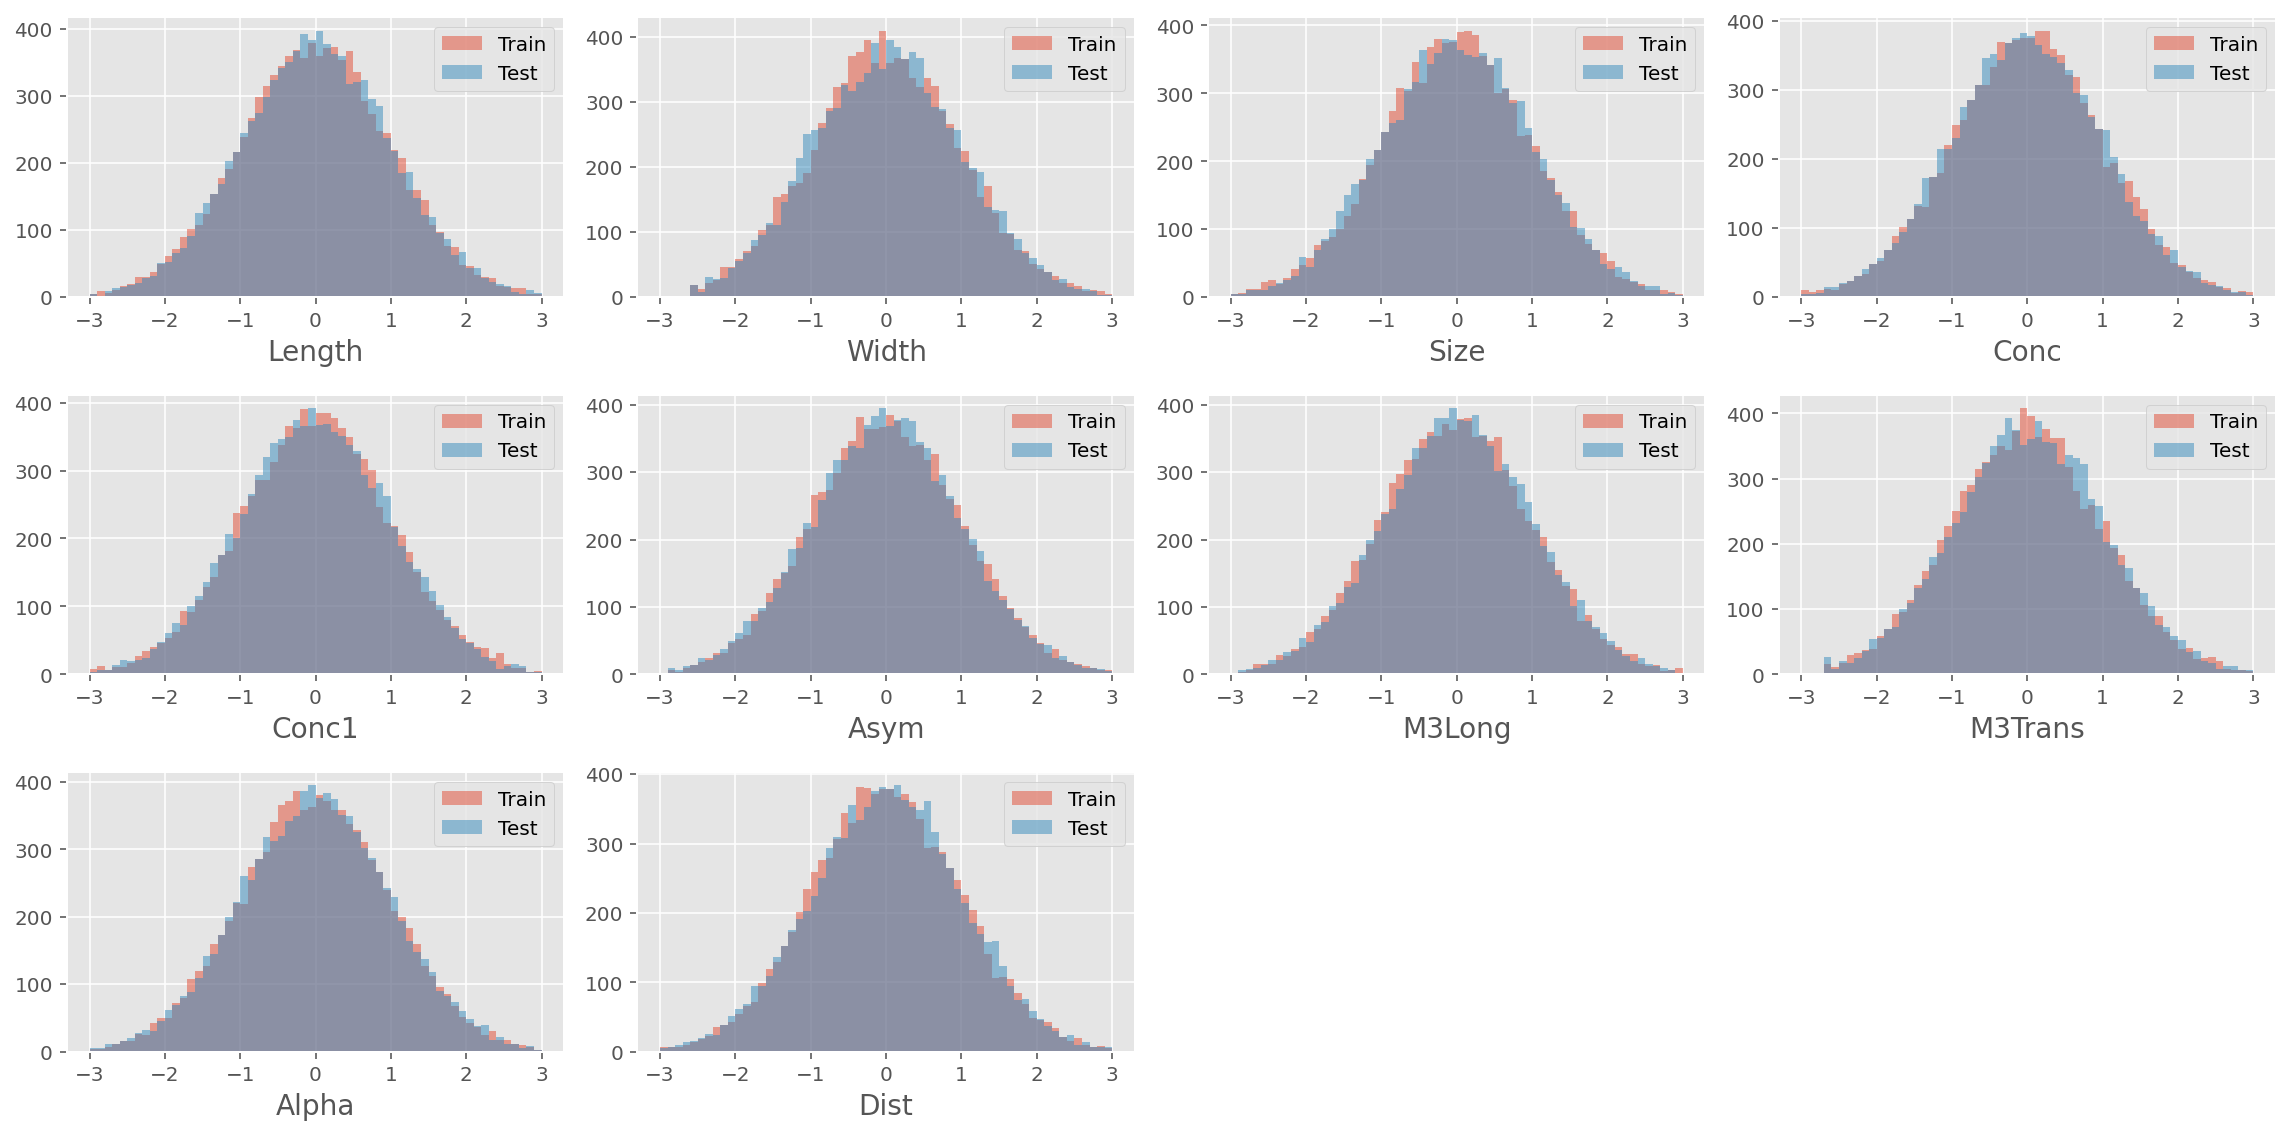

In [13]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** — адрон, **1** — фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="https://github.com/khaykingleb/Applied-Data-Science/blob/main/homeworks/hw_01/img/cgan.png?raw=1" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + \frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [14]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

## Задание 2 (1 балл)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой с 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой с 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [15]:
class Generator(nn.Module):
    
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        self.net = nn.Sequential(nn.Linear(in_features=n_inputs, out_features=100),
                                 nn.BatchNorm1d(num_features=100),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(in_features=100, out_features=100),
                                 nn.BatchNorm1d(num_features=100),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(in_features=100, out_features=n_outputs))

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 3 (1 балл)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [16]:
class Discriminator(nn.Module):
    
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(nn.Linear(in_features=n_inputs, out_features=100),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(in_features=100, out_features=100),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(in_features=100, out_features=1))


    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## Задание 4 (2 балла)

Реализуйте класс для обучения генеративной модели.

Сначала рализуем функцию потерь для нашего CGANа.

In [42]:
def wgan_loss(real_objects_scores: torch.Tensor,
              generated_objects_scores: torch.Tensor, 
              by: Literal['generator', 'discriminator'] = 'generator') -> torch.Tensor:
  '''
  Имплементирует подсчет лосса для генератора и дискриминатора WGAN.
  '''
  if by=='generator':
    # возвращает лосс генератора
    return -torch.mean(generated_objects_scores)
  elif by == 'discriminator':
    # return discriminator loss
    return -torch.mean(real_objects_scores) + torch.mean(generated_objects_scores)

Теперь перейдем к реализации класса.

In [43]:
class Fitter(object):
    def __init__(self, generator, discriminator, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        self.opt_gen  = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        
        self.generator.to(device)
        self.discriminator.to(device)
    
    
    def fit(self, X, y):
        # Numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=device)
        y_cond = torch.tensor(y, dtype=torch.float, device=device)
        
        # Tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)
        
        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)
        
        self.loss_history = []

        iter_i = 0

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_objects, y_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):              
                # Генерируем шум
                num_objects = real_objects.shape[0]
                z_noise = torch.normal(0, 1, (num_objects, self.latent_dim))
                gen_objects = self.generator(z_noise.to(device), y_batch.to(device))

                # Считаем выходы на дискриминаторе
                real_objects_scores, gen_objects_scores = torch.split(discriminator(torch.cat([real_objects, gen_objects], dim=0), 
                                                                                    torch.cat([y_batch, y_batch], dim=0)), 
                                                                      num_objects)
              
                if iter_i % (1 + self.n_critic) == 0:
                    # Обучаем генератор
                    self.opt_gen.zero_grad()
                    gen_loss = wgan_loss(real_objects_scores, gen_objects_scores, 'generator')
                    gen_loss.backward()
                    self.opt_gen.step()
                else:
                    # Обучаем дискриминатор
                    self.opt_disc.zero_grad()
                    disc_loss = wgan_loss(real_objects_scores, gen_objects_scores, 'discriminator')
                    disc_loss.backward()
                    self.opt_disc.step()

                # Делаем клиппинг весов для дискриминатора
                for p in self.discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)

                iter_i += 1

            # Calculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise.to(device), y_cond.to(device))
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(self.discriminator(X_fake, y_cond))
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [44]:
latent_dim = 10
generator = Generator(n_inputs=latent_dim+y.shape[1], 
                      n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1]+y.shape[1])

In [45]:
%%time
fitter = Fitter(generator, discriminator, batch_size=50, n_epochs=100, latent_dim=latent_dim, lr=0.0001, n_critic=5)
fitter.fit(X_train, y_train)

CPU times: user 53.7 s, sys: 958 ms, total: 54.7 s
Wall time: 55.2 s


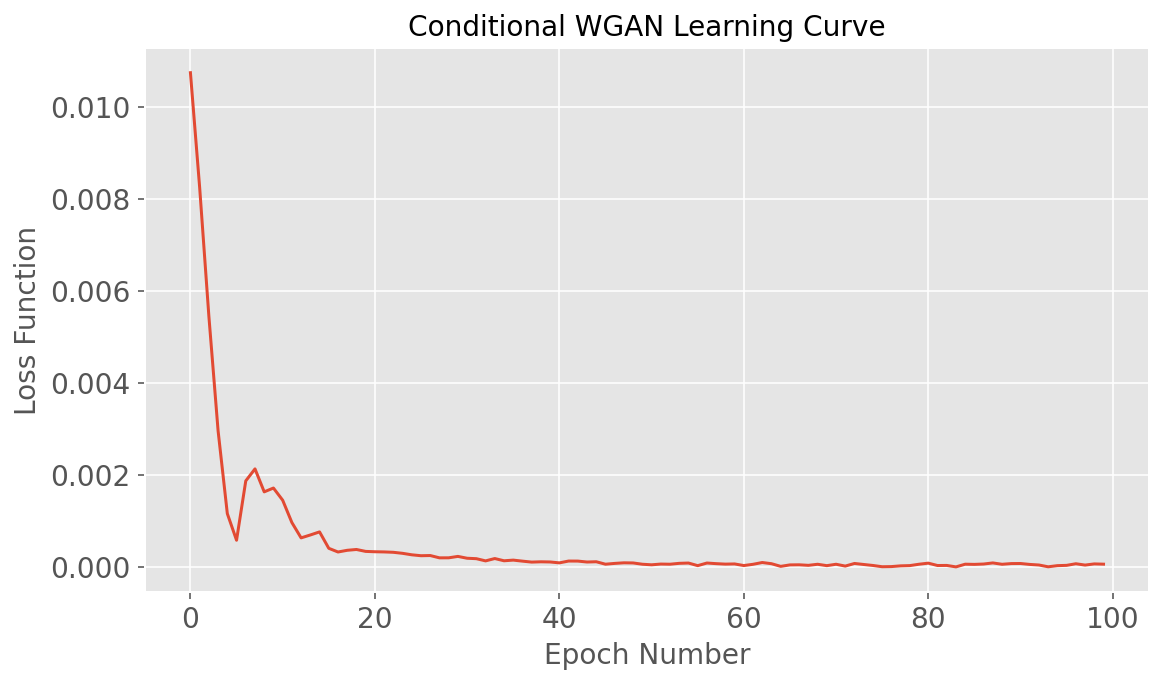

In [46]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
#plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

## Задание 5 (1 балл)

Реализуйте функцию для генерации новых объектов $X$ по вектору условий $y$.

In [47]:
def generate(generator, y, latent_dim):
    # Генерируем шум
    z = torch.normal(0, 1, (y.shape[0], latent_dim))
    # Переводим в тензоры
    z = torch.tensor(z, dtype=torch.float, device=device)
    y = torch.tensor(y, dtype=torch.float, device=device)
    # Подаем на вход генератору и получаем фейковые объекты
    X_fake = generator(z, y)
    
    return X_fake.cpu().detach().numpy()

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`

In [48]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


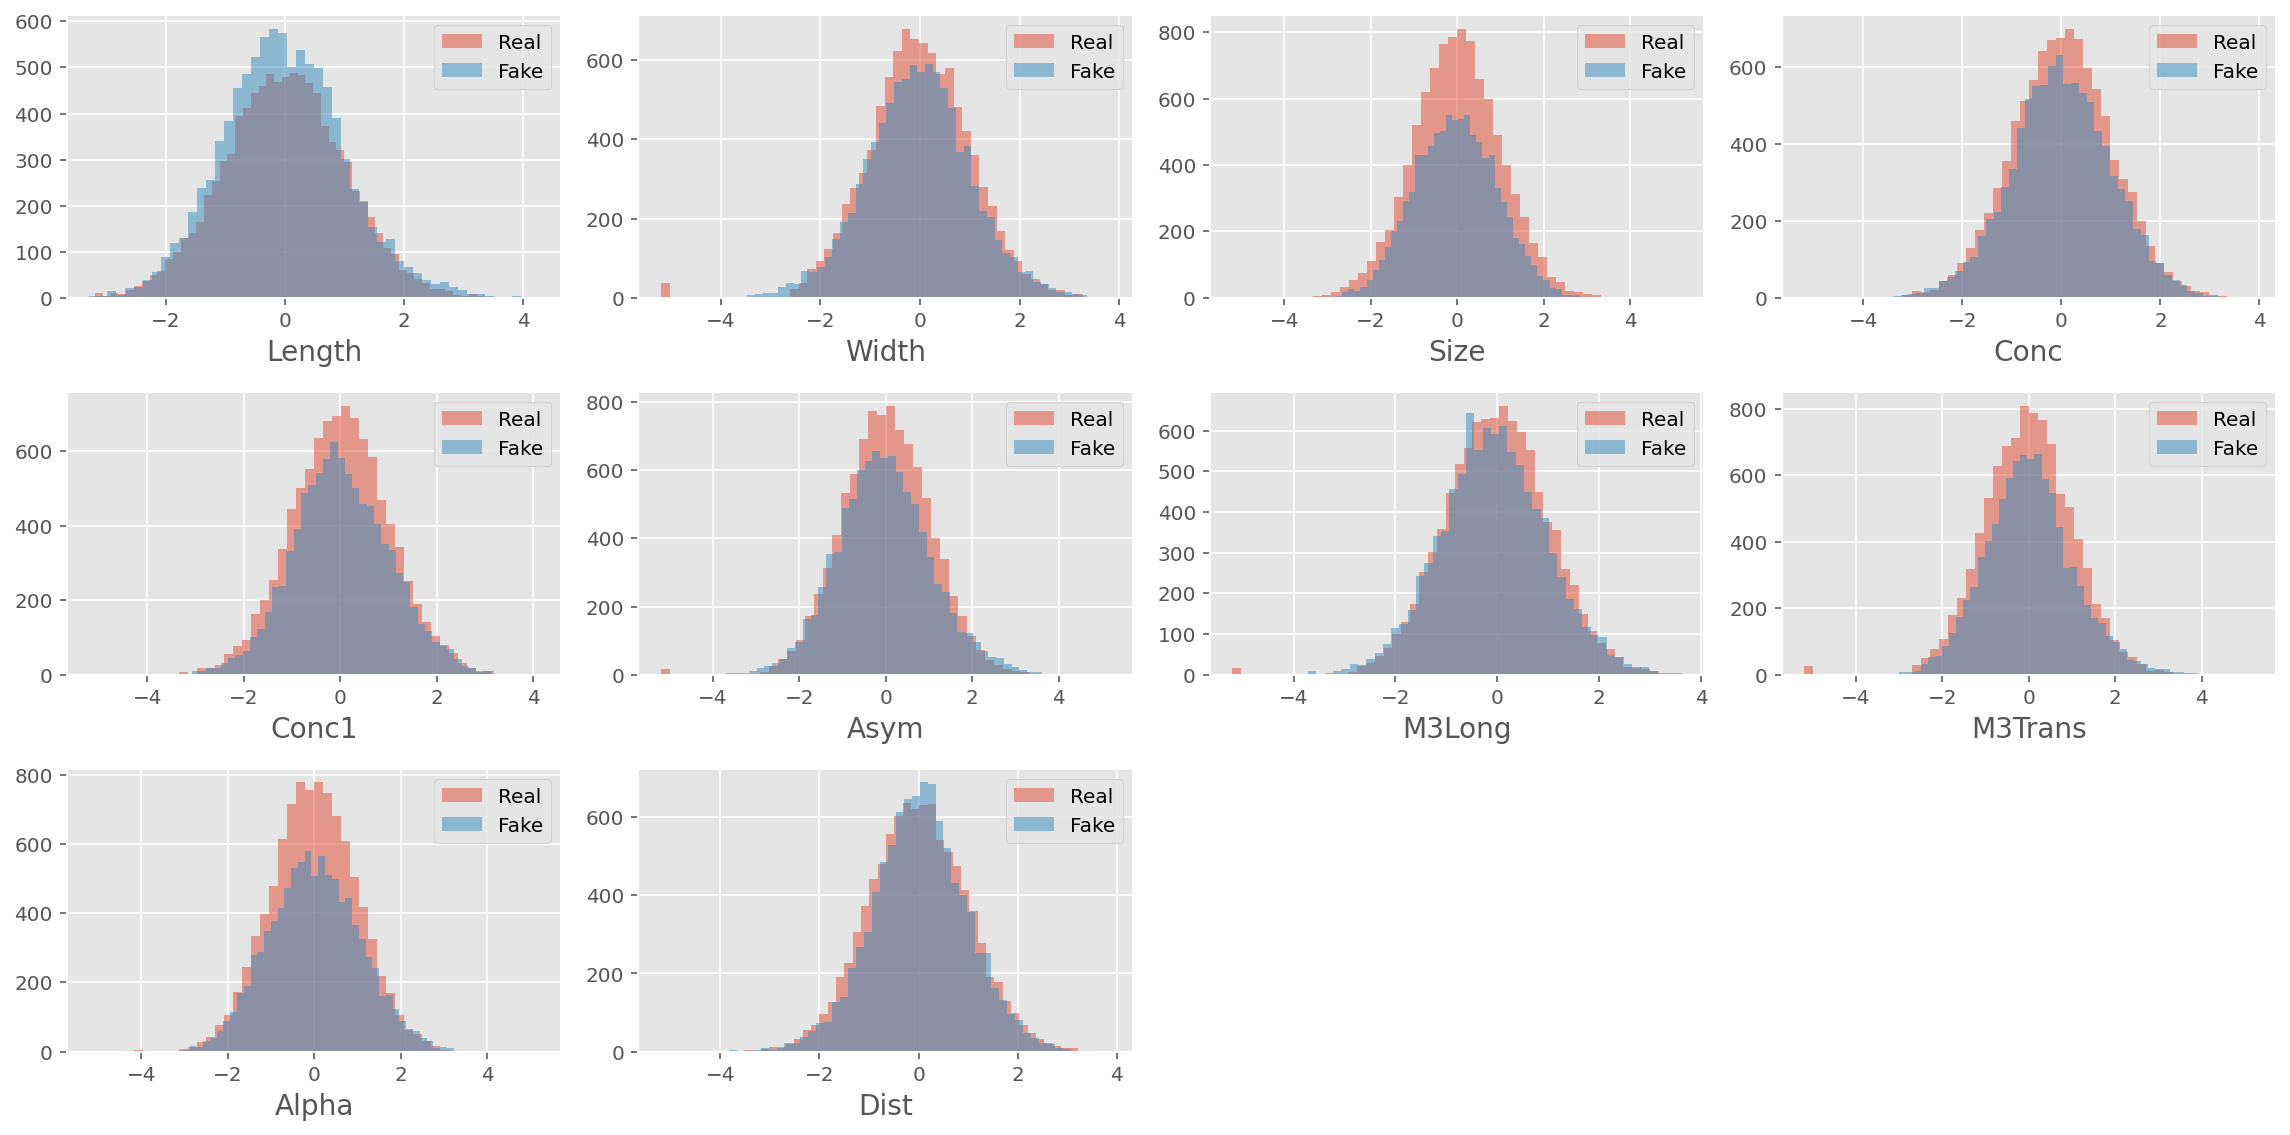

In [49]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [50]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


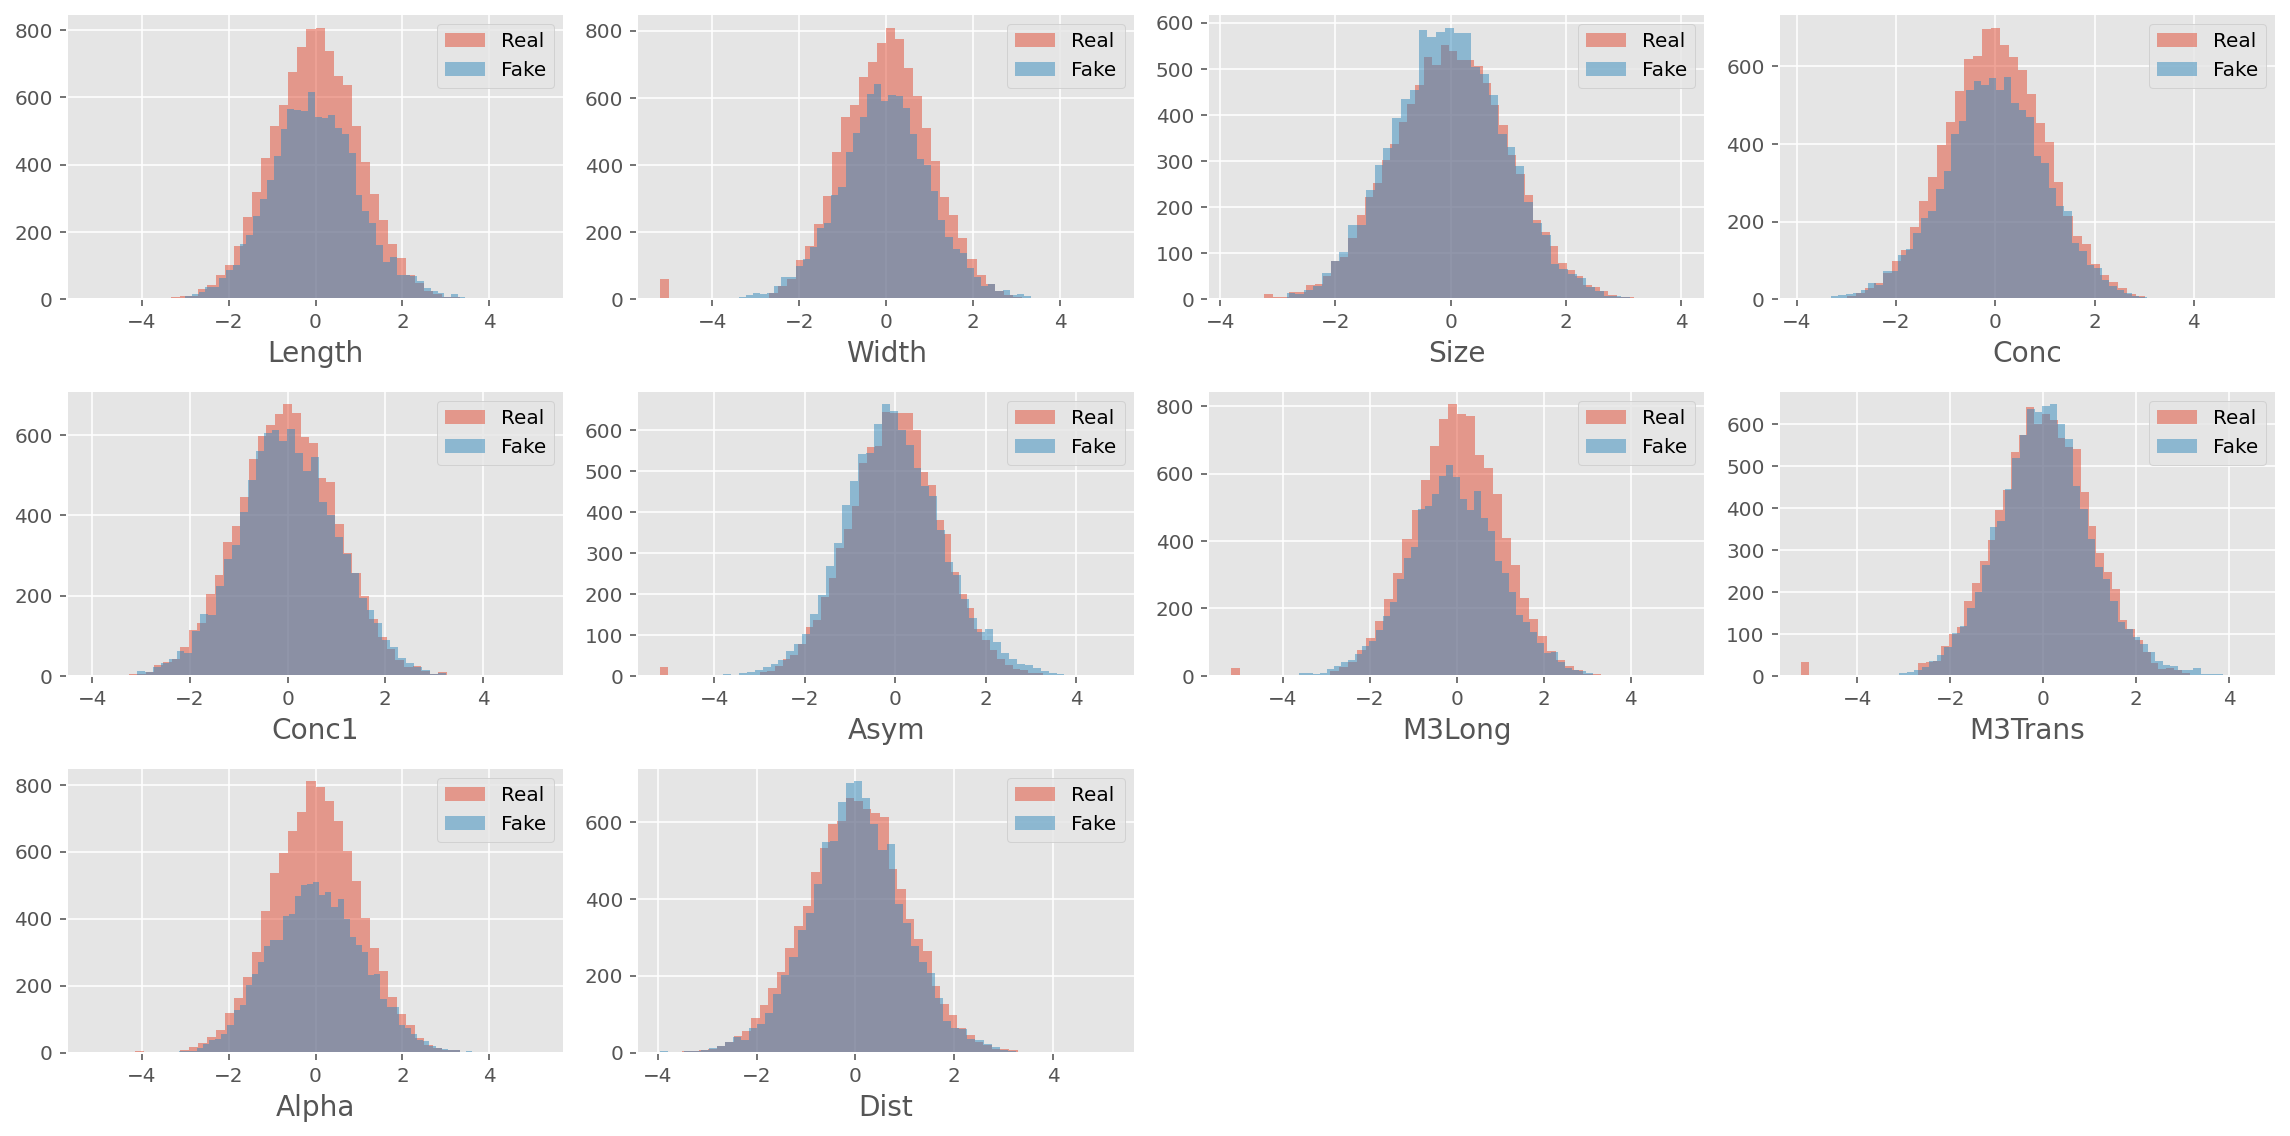

In [51]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод 1: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="https://github.com/khaykingleb/Applied-Data-Science/blob/main/homeworks/hw_01/img/clf.png?raw=1" width="600"></center>

Измерим сходство распределений классификатором.

In [52]:
# Собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [54]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.676137283129939


## Вывод 2

Идеальное значение ROC AUC равно 0.5. Это соответствует случаю, когда классификатор не может разделить реальные и фейковые данные. В нашем случае ROC AUC около 0.7, что говорит о том, что есть куда улучшать качество генеративной модели :)

# Условные вариационные автокодировщики

<center><img src="https://github.com/khaykingleb/Applied-Data-Science/blob/main/homeworks/hw_01/img/cvae.svg?raw=1" width="600"></center>

Теперь, решим эту же задачу используя условный автокодировщик (CVAE). 

## Задание 6 (1 балл)

Реализуйте нейронную сеть для декодеровщика со следующими слоями:
- Полносвязный слой с 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой с 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой для mu; Выходной слой для log_sigma;

Подсказка: используйте функцию `nn.Sequential()`.

In [55]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()
        self.enc_net  = nn.Sequential(nn.Linear(n_inputs, 100),
                                      nn.BatchNorm1d(100),
                                      nn.ReLU(inplace=True),
                                      nn.Linear(100, 100),
                                      nn.BatchNorm1d(100),
                                      nn.ReLU(inplace=True))
        
        self.mu = nn.Linear(100, lat_size)
        self.log_sigma = nn.Linear(100, lat_size)
        
    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma 

## Задание 7 (1 балл)

Реализуйте нейронную сеть для декодеровщика со следующими слоями:
- Полносвязный слой с 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой с 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [56]:
class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()
        
        self.dec_net = nn.Sequential(nn.Linear(in_features=n_inputs, out_features=100),
                                     nn.ReLU(),
                                     nn.Linear(in_features=100, out_features=100),
                                     nn.ReLU(),
                                     nn.Linear(in_features=100, out_features=n_outputs))
        
    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

## Задание 8 (1 балл)

Реализуйте класс для обучения вариационного автокодировщика.

In [57]:
class VAEFitter(object):
    def __init__(self, encoder, decoder, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, KL_weight=0.001):
        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight
        
        self.criterion = nn.MSELoss()
        self.opt  = torch.optim.RMSprop(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)
        
        self.encoder.to(device)
        self.decoder.to(device)
        
        
    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(device)
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
        recon_loss = self.criterion(x, rec_x)
        return KL*self.KL_weight + recon_loss
    
    
    def compute_loss(self, x_batch, cond_batch):
        mu, log_sigma = self.encoder(x_batch, cond_batch)
        z = self.sample_z(mu, log_sigma)
        x_rec = self.decoder(z, cond_batch)
        loss = self.custom_loss(x_batch, x_rec, mu, log_sigma)
        return loss
    
    
    def fit(self, X, y):
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=device)
        y_cond = torch.tensor(y, dtype=torch.float, device=device)
        
        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)
        
        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)
        
        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)
                
                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                    
            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

## Обучение
Обучим модель на данных.

In [58]:
%%time

latent_dim = 10

encoder = Encoder(n_inputs=X_train.shape[1]+y.shape[1], lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim+y.shape[1], n_outputs=X_train.shape[1])

vae_fitter = VAEFitter(encoder, decoder, batch_size=50, n_epochs=100, latent_dim=latent_dim, lr=0.001, KL_weight=0.001)
vae_fitter.fit(X_train, y_train)

CPU times: user 1min 17s, sys: 1.19 s, total: 1min 18s
Wall time: 1min 19s


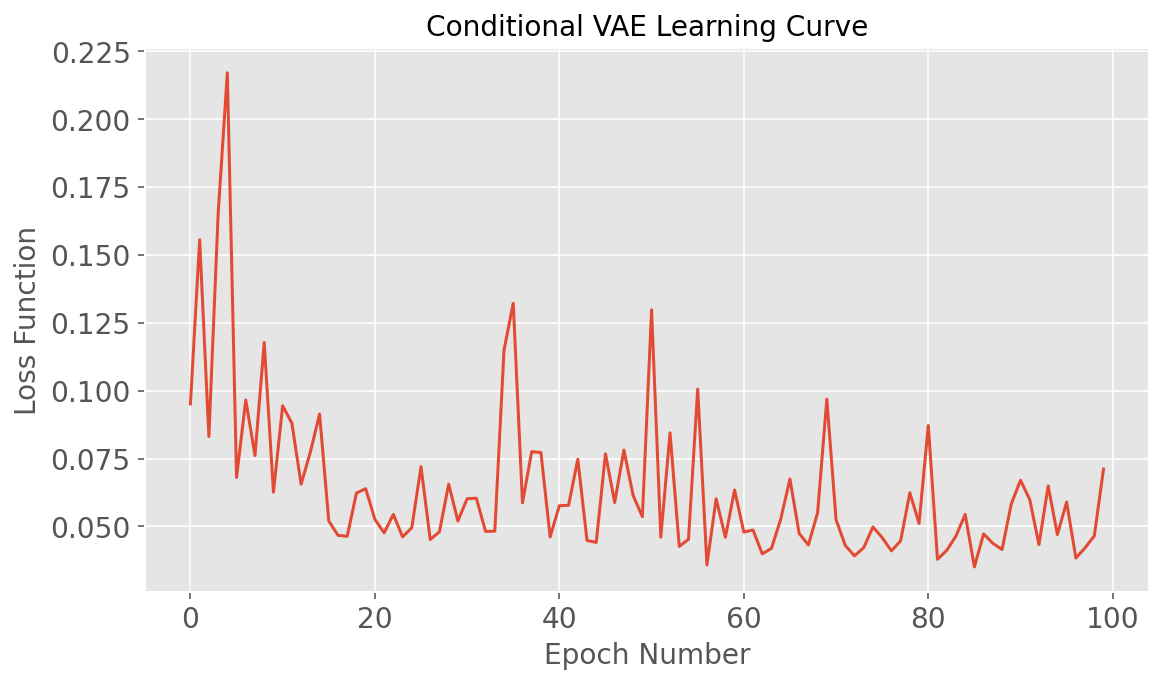

In [59]:
# CVAE learning curve
plt.figure(figsize=(9, 5))
plt.plot(vae_fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional VAE Learning Curve", size=14)
#plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

## Задание 9 (1 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [60]:
def generate(decoder, y, latent_dim):
    # Генерируем шум
    z = torch.normal(0, 1, (y.shape[0], latent_dim))
    # Переводим в тензоры
    z = torch.tensor(z, dtype=torch.float, device=device)
    y = torch.tensor(y, dtype=torch.float, device=device)
    # Подаем на вход декодеру и получаем фейковые объекты
    X_fake = decoder(z, y)
    return X_fake.cpu().detach().numpy()

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`

In [61]:
X_fake_train = generate(vae_fitter.decoder, y_train, latent_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


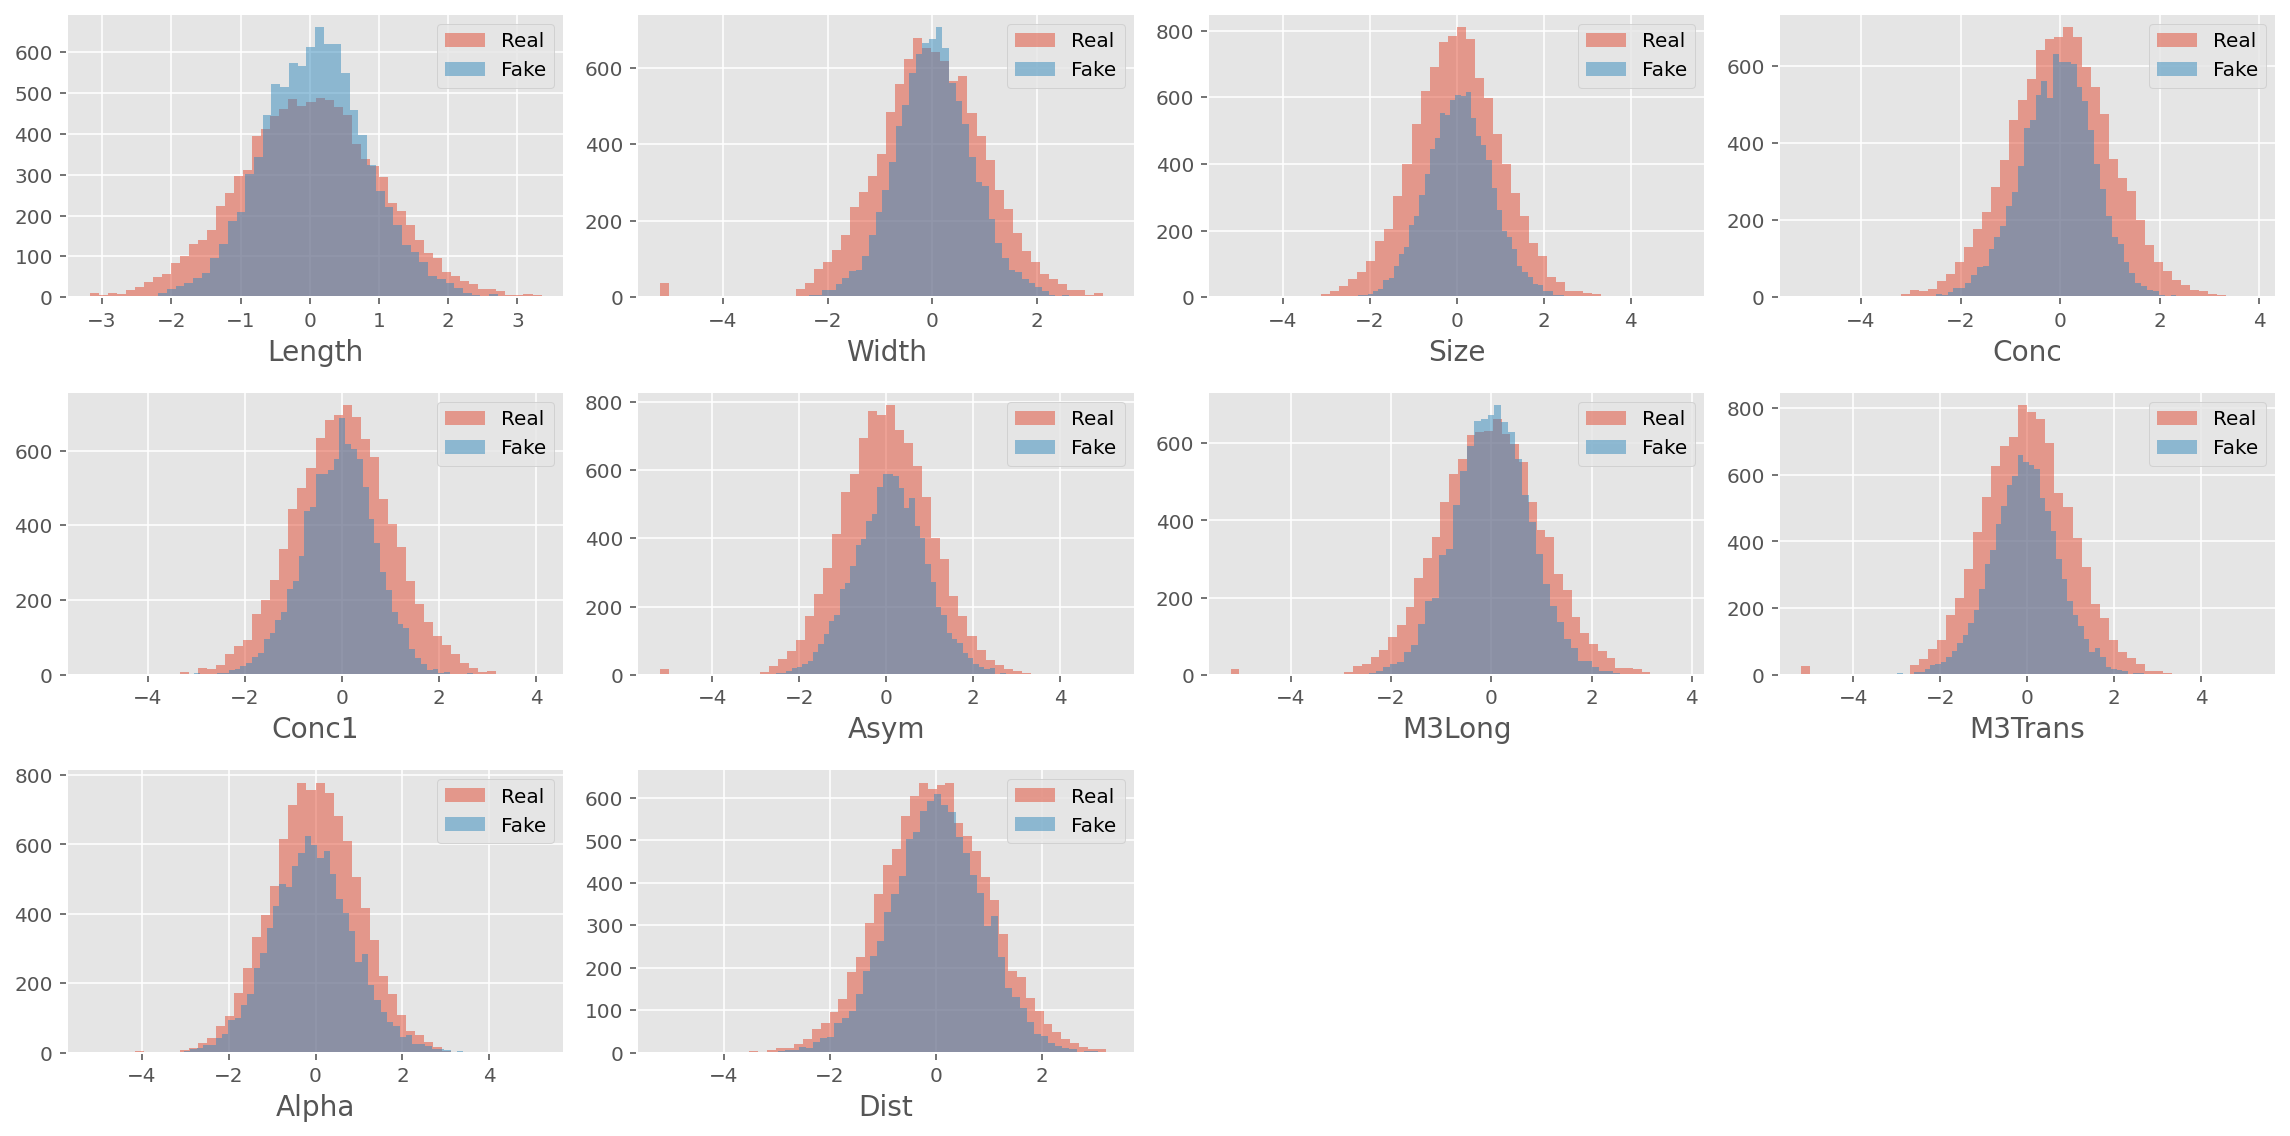

In [62]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [63]:
X_fake_test = generate(vae_fitter.decoder, y_test, latent_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


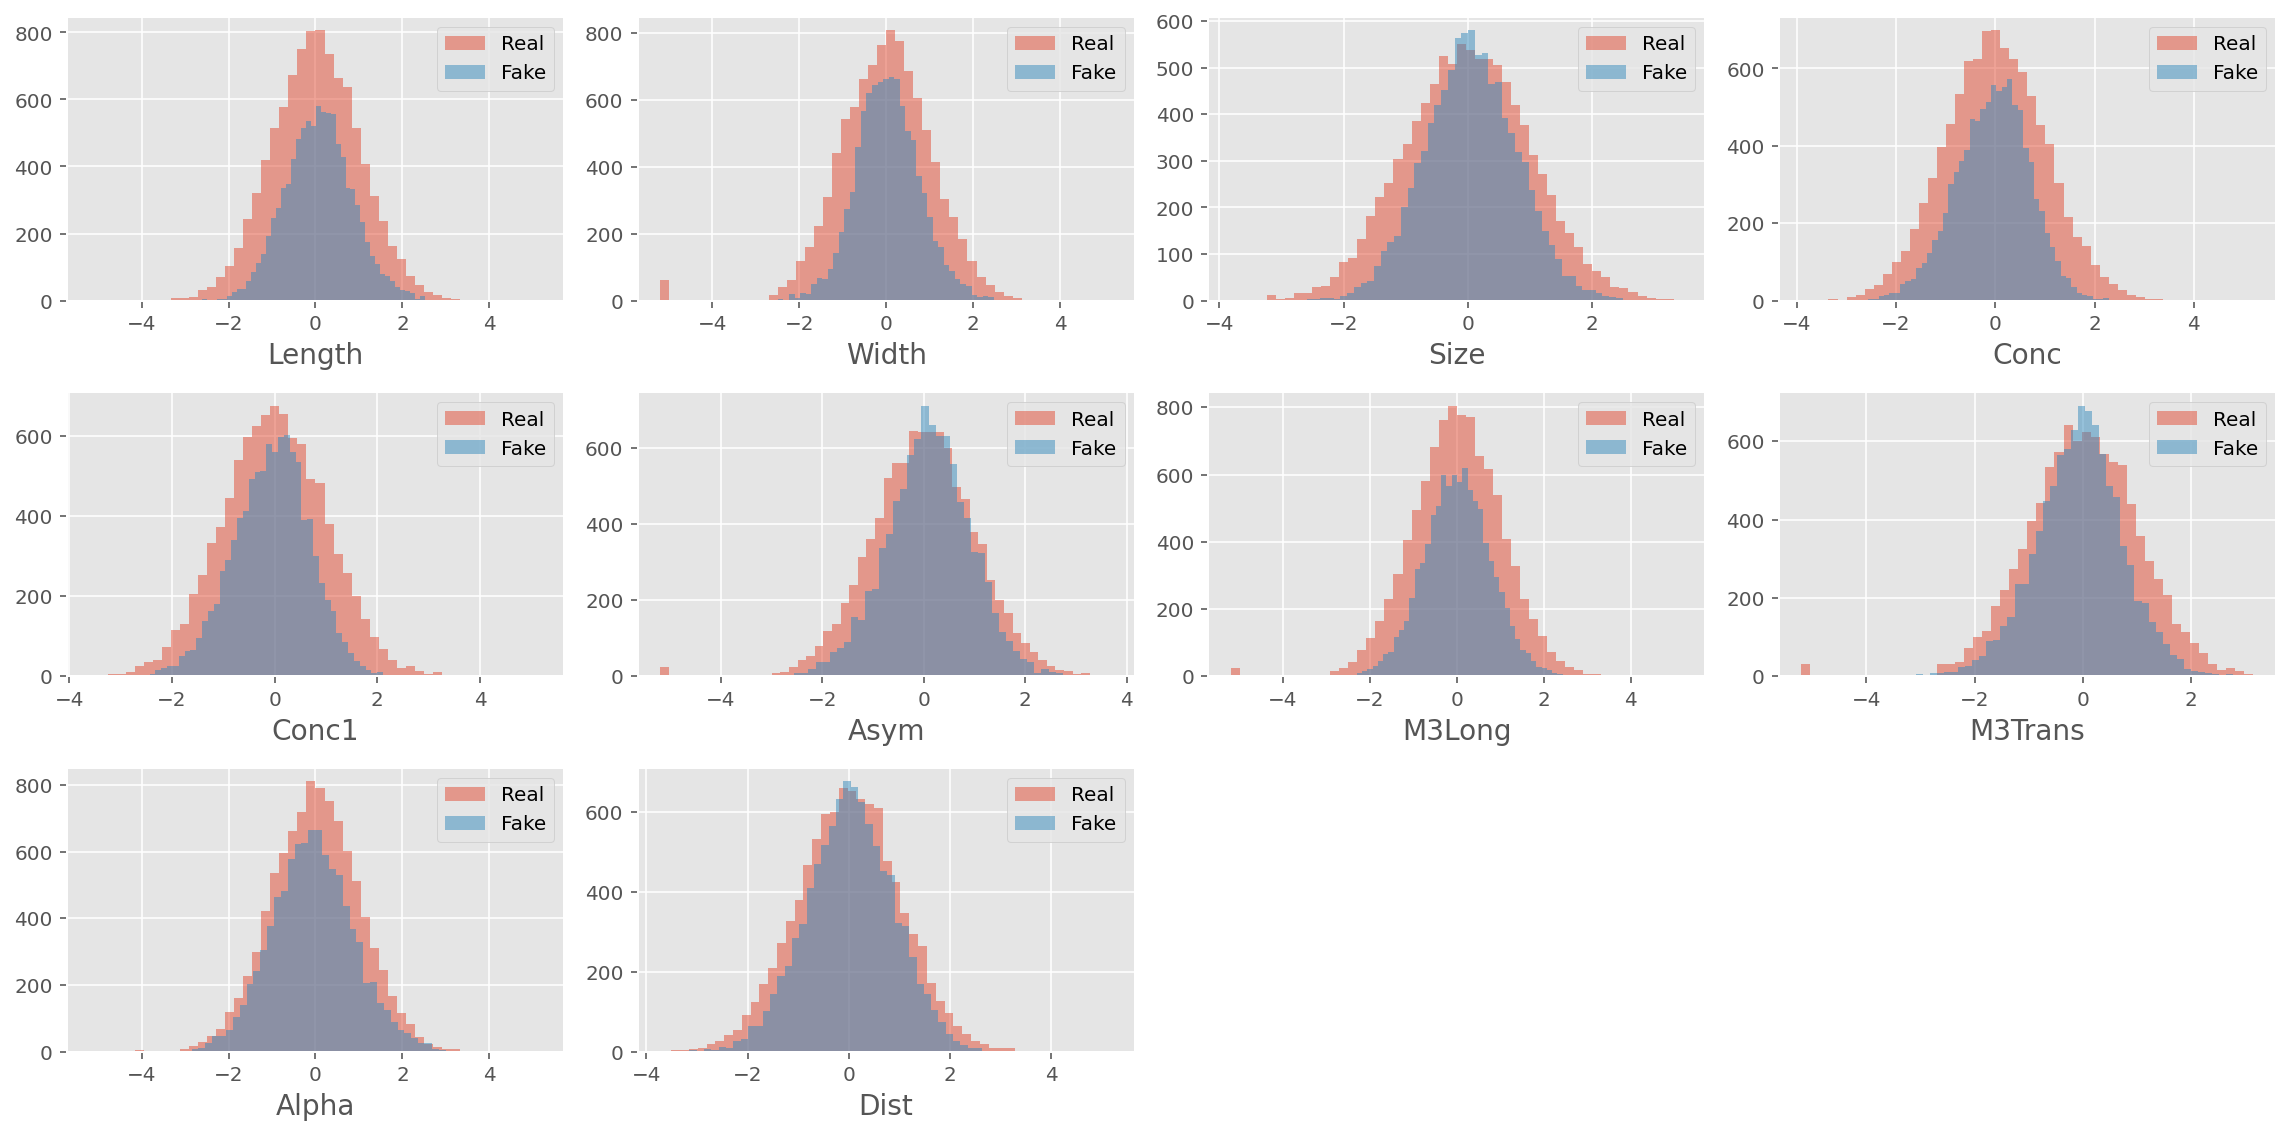

In [64]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

# Измерение качества генерации

Измерим сходство распределений классификатором.

In [65]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [67]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7258142350572367


## Вывод 3

Для CVAE получили ROC AUC около 0.7 (меньше лучше). Таким образом видим, что в данной задаче обе модели ведут себя схожим образом. Но может их можно как-то улучшить? Или есть какая-то еще модель? :)

<center><img src="https://github.com/khaykingleb/Applied-Data-Science/blob/main/homeworks/hw_01/img/mem1.jpg?raw=1" width="500"></center>

<center><img src="https://github.com/khaykingleb/Applied-Data-Science/blob/main/homeworks/hw_01/img/mem2.jpg?raw=1" width="500"></center>